# installing packages and necessary dependencies

In [ ]:
!pip install pandas==2.2.2 \
             numpy==1.26.4  \
             matplotlib==3.10.0 \
             seaborn==0.13.2 \
             scienceplots==2.1.1 \
             scikit-learn==1.5.2 \
             optuna==4.2.0 \
             scipy==1.13.1 \
             tqdm==4.67.1 \
             puncc==0.8.0 \
             mapie==0.9.2 \
             scikit-lego==0.9.4  \
             catboost==1.2.7 \
             shapiq==1.2.0 \
             -q



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.4 MB/s eta 0:00:00


In [ ]:
!mkdir results
!mkdir results/eda
!mkdir results/modeling
!mkdir results/modeling/lasso
!mkdir results/interpretation

# Importing necessary packages

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import *
from sklearn.metrics import *
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import *

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

from sklearn.feature_selection import mutual_info_regression

from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

import optuna

import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

import joblib

import warnings
import gc

from sklearn import set_config

from sklego.feature_selection import MaximumRelevanceMinimumRedundancy
from sklearn.feature_selection import f_regression


import shap
import shapiq

# Global configuration


1.   matplotlib scientific config
2.   sklearn config (pandas output)
3.   random state, n_trials, handling warnings


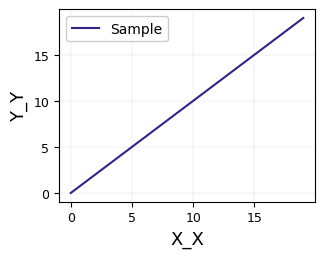

In [ ]:
plt.rcdefaults()

plt.style.use(['ieee', 'grid', 'muted'])

COLORS = {
    'indigo':"#332288",
    'cyan': "#88CCEE",
    'teal': "#44AA99",
    'green': "#117733",
    'olive': "#999933",
    'sand': "#DDCC77",
    'rose': "#CC6677",
    'wine': "#882255",
    'purple': "#AA4499",
    'grey': "#DDDDDD",
}

mpl_global_config = {
    'font.family': ['sans'],
    'figure.dpi': 100,
    'savefig.dpi': 1500,
    'savefig.transparent': False,
    'savefig.bbox': 'tight',
    'axes.axisbelow': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.labelsize': 13,
    'legend.fontsize': 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    'grid.linewidth': 0.12,
    'grid.linestyle': '--',
}

%matplotlib inline

plt.rcParams.update(mpl_global_config)

plt.plot(range(20), c=COLORS['indigo'], label="Sample")
plt.xlabel("X_X")
plt.ylabel("Y_Y")
plt.legend(fancybox=True)


In [ ]:
set_config(transform_output="pandas")

SEED = 42

n_trials = 200

warnings.filterwarnings("ignore")


TARGET_NAME = 'Corrosion Rate'

# Helper functions

1.   Summarize Data
2.   Plot Correlation Heatmap
3.   Plot Models' Performance
4.   Summarize Model's Performance in a csv File



In [ ]:
def summarize_data(df, filename):
    """
    Summarizes the given DataFrame and saves the summary to a CSV file.

    Parameters:
    df (DataFrame): The DataFrame to summarize. This is the input data that will be analyzed.
    filename (str): The name of the file to save the summary. This is the output file where the summary will be stored.
    """

    data_summary = df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    data_summary.loc["Missing Values Ratio"] = df.isnull().sum().divide(len(df))
    data_summary.loc["Unique Values Ratio"] = df.nunique().divide(len(df))
    data_summary.loc["Kurtosis"] = df.kurtosis()
    data_summary.loc["Skewness"] = df.skew()
    data_summary.T.round(3).to_csv(filename)

In [ ]:
def plot_corr_heatmap(df, ax=None, method='pearson', cmap='coolwarm', triangular=False,
                      handle_missing=None, figsize=(10, 8), use_title=True):
    """
    Plots a correlation heatmap for the given DataFrame.

    Parameters:
    df (DataFrame): The DataFrame for which to plot the correlation heatmap.
    ax (Axes): The Axes object to draw the heatmap on. If None, a new figure is created.
    method (str): The method to compute the correlation ('pearson', 'kendall', 'spearman').
    cmap (str): The colormap to use for the heatmap.
    triangular (bool): If True, only show the upper triangle of the heatmap.
    handle_missing (str): How to handle missing values ('mean', 'median', or None).
    figsize (tuple): Size of the figure (width, height).
    use_title (bool): If True, adds a title to the plot.

    Returns:
    ax: The Axes object containing the heatmap.
    """
    if handle_missing == 'mean':
        df = df.fillna(df.mean())
    elif handle_missing == 'median':
        df = df.fillna(df.median())
    elif handle_missing == 'zeros':
        df.fillna(0)

    corr = df.corr(method=method)

    mask = None
    if triangular:
        mask = np.triu(np.ones_like(corr, dtype=bool))

    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f",
                 square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax)

    if use_title:
        ax.set_title(f'Correlation Heatmap ({method} method)', fontsize=16)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    return ax


In [ ]:
def plot_actual_vs_predicted(model, X, y, target_name, save_file=False, color="blue", figsize=(3.3, 2.5), dataset="Test", model_name=None):
    """
    Plot the actual vs predicted values for a given model.

    Parameters:
    - model: The model used for predictions.
    - X: The features.
    - y: The actual targets.
    - target_name: The name of the target variable.
    - save_file: Optional file path to save the plot. If None, the plot will not be saved.
    - color: The color for the scatter points. Default is 'blue'.
    - figsize: The size of the figure. Default is (3.3, 2.5).
    """

    fig, ax = plt.subplots(figsize=figsize)

    r2 = np.round(r2_score(y, model.predict(X)), 3)

    label = "$R^2_{\t{Test}}:$" + f"{r2}" if dataset == "Test" else "$R^2_{\t{Train}}:$" + f"{r2}"

    PredictionErrorDisplay.from_estimator(
        model,
        X,
        y,
        kind="actual_vs_predicted",
        scatter_kwargs={
            "color": color,
            "alpha": 1,
            "label": label
        },
        line_kwargs={"color": "#BBBBBB"},
        ax=ax,
    )

    ax.legend()
    ax.set_ylabel(f"Actual {target_name}", fontsize=11)
    ax.set_xlabel(f"Predicted {target_name}", fontsize=11)

    if save_file:
        plt.savefig(f"results/modeling/{model_name}_{dataset}_actual_vs_predicted.png")

    plt.show()


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, save=False, model_name=None):
    """
    Evaluates a given model and returns performance metrics as a pandas DataFrame.

    Args:
        model: The trained machine learning model.
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target variable.
        y_test: Testing target variable.

    Returns:
        A pandas DataFrame containing the model's performance metrics.
    """

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE', 'R2'],
        'Train': [
            mean_absolute_error(y_train, y_pred_train),
            mean_squared_error(y_train, y_pred_train),
            np.sqrt(mean_squared_error(y_train, y_pred_train)),
            mean_absolute_percentage_error(y_train, y_pred_train),
            r2_score(y_train, y_pred_train)
        ],
        'Test': [
            mean_absolute_error(y_test, y_pred_test),
            mean_squared_error(y_test, y_pred_test),
            np.sqrt(mean_squared_error(y_test, y_pred_test)),
            mean_absolute_percentage_error(y_test, y_pred_test),
            r2_score(y_test, y_pred_test)
        ]
    }

    result = pd.DataFrame(metrics)
    if save:
        result.to_csv(f"results/modeling/{model_name}_performance_result.csv")

    return result

# Data cleansing

1.   Rename Columns
2.   Concatenate Both DataFrames



In [ ]:
file_path = "Dataset of Steel Corrosion in Cementitious Mortar Due to Carbonation and Chlorides.xlsx"

carbonation = pd.read_excel(file_path, sheet_name='01_Carbonation', skiprows=2, dtype=float)
chloride = pd.read_excel(file_path, sheet_name='02_Chloride', skiprows=2, dtype=float)

carbonation_columns = [
    'Cement Proportion',
    'GGBS Proportion',
    'Fly Ash Proportion',
    'Silic Fume Proportion',
    'Water to Binder Ratio, Unit:1',
    'Incorporated Chloride Concentration of mortar, Unit: wt.%',
    'Free Chloride Concentration of mortar, Unit: wt.%',
    'pH value of Pore Solution of mortar, Unit: 1',
    'Porosity of mortar, Unit: 1',
    'Relative Humidity of Environment, Unit: %',
    'Degree of Saturation of mortar, Unit: 1',
    'Water Content of mortar, Unit: %',
    'Corrosion Potential of Steel vs Cu/CuSO4 reference electrode, Unit: mV',
    'Electrical Resistivity of mortar, Unit: ohm·m',
    'Chloride-to-hydroxide concentration ratio, Unit: 1',
    'Corrosion Rate of Steel, Unit: uA/cm2',
    "wt.% is the percentage with respect to the binder mass"
]

chloride_columns = [
    'Cement Proportion',
    'GGBS Proportion',
    'Fly Ash Proportion',
    'Water to Binder Ratio, Unit:1',
    'Incorporated Chloride Concentration of mortar, Unit: wt.%',
    'Free Chloride Concentration of mortar, Unit: wt.%',
    'pH value of Pore Solution of mortar, Unit: 1',
    'Porosity of mortar, Unit: 1',
    'Relative Humidity of Environment, Unit: %',
    'Degree of Saturation of mortar, Unit: 1',
    'Water Content of mortar, Unit: %',
    'Corrosion Potential of Steel vs Cu/CuSO4 reference electrode, Unit: mV',
    'Electrical Resistivity of mortar, Unit: ohm·m',
    'Chloride-to-hydroxide concentration ratio, Unit: 1',
    'Corrosion Rate of Steel, Unit: uA/cm2',
    'wt.% is the percentage with respect to the binder mass'
]

carbonation.columns = carbonation_columns
chloride.columns = chloride_columns

carbonation = carbonation.drop(columns=['wt.% is the percentage with respect to the binder mass'])

carbonation["contamination_type"] = 0
chloride["contamination_type"] = 1

chloride = chloride.drop(columns=['wt.% is the percentage with respect to the binder mass'])

new_column_names = {
    'Cement Proportion': 'Cement',
    'GGBS Proportion': 'GGBS',
    'Fly Ash Proportion': 'FA',
    'Silic Fume Proportion': 'SF',
    'Water to Binder Ratio, Unit:1': 'W/B',
    'Incorporated Chloride Concentration of mortar, Unit: wt.%': 'ICC',
    'Free Chloride Concentration of mortar, Unit: wt.%': 'FCC',
    'pH value of Pore Solution of mortar, Unit: 1': 'pH',
    'Porosity of mortar, Unit: 1': 'Porosity',
    'Relative Humidity of Environment, Unit: %': 'RH',
    'Degree of Saturation of mortar, Unit: 1': 'DoS',
    'Water Content of mortar, Unit: %': 'WaterC',
    'Corrosion Potential of Steel vs Cu/CuSO4 reference electrode, Unit: mV': 'CP',
    'Electrical Resistivity of mortar, Unit: ohm·m': 'ER',
    'Chloride-to-hydroxide concentration ratio, Unit: 1': '[Cl]/[OH]',
    'contamination_type': 'CT',
    'Corrosion Rate of Steel, Unit: uA/cm2': 'Corrosion Rate'
}

df = pd.concat([chloride, carbonation], axis=0)
df = df.reset_index(drop=True)

df = df.rename(columns=new_column_names)
df["SF"] = df["SF"].fillna(0)
df.insert(3, 'SF', df.pop('SF'))

TARGET = 'Corrosion Rate'
y = df[TARGET]
X = df.drop(columns=[TARGET])
df = pd.concat([X, y], axis=1)
df.head()

,Cement,GGBS,FA,SF,W/B,ICC,FCC,pH,Porosity,RH,DoS,WaterC,CP,ER,[Cl]/[OH],CT,Corrosion Rate
0,100.0,0.0,0.0,0.0,0.45,0.0,0.01090,14.166076,0.212085,100.0,1.0,10.604236,-358.466667,32.346828,0.009186,1,0.009239
1,100.0,0.0,0.0,0.0,0.45,1.0,0.74948,14.471547,0.265621,100.0,1.0,13.281037,-228.333333,38.442859,0.279558,1,0.043442
2,100.0,0.0,0.0,0.0,0.45,2.0,1.53446,14.482860,0.237826,100.0,1.0,11.891302,-692.733333,39.748199,0.549120,1,0.299889
3,100.0,0.0,0.0,0.0,0.45,3.0,2.23787,14.459298,0.242229,100.0,1.0,12.111442,-665.000000,44.600223,0.858117,1,0.189601
4,100.0,0.0,0.0,0.0,0.40,2.0,1.52556,14.167413,0.227730,100.0,1.0,11.386480,-654.083333,51.206923,1.327825,1,0.248579


# EDA

1.   Unique Values
2.   Statistical Summary
3.   Pearson and Spearman Correlation
4.   f-regression
5.   Feature Clustering



In [ ]:
threshold = 20

with open('results/eda/unique_values.txt', 'w') as f:
    for column in df.select_dtypes(include='number').columns:
        unique_values = df[column].unique()

        if len(unique_values) <= threshold:
            f.write(f"Column '{column}' has {len(unique_values)} unique values: {unique_values}\n")



In [ ]:
summarize_data(df, "results/eda/short_statistical_report_for_paper.csv")

In [ ]:
# pearson_cmap = plt.cm.PuBuGn

# # Create and save Pearson correlation heatmap
# fig1, ax1 = plt.subplots(figsize=(9, 7))  # Create a figure and Axes for Pearson
# plot_corr_heatmap(df, ax=ax1, method='pearson', cmap=pearson_cmap,
#                   triangular=True, handle_missing='zeros', use_title=False)
# plt.savefig('results/eda/pearson_correlation_heatmap.png')  # Save Pearson heatmap
# plt.close(fig1)  # Close the figure

In [ ]:
# Create and save Spearman correlation heatmap
spearman_cmap = plt.cm.PRGn
fig2, ax2 = plt.subplots(figsize=(9, 7))  # Create a figure and Axes for Spearman
plot_corr_heatmap(df, ax=ax2, method='spearman', cmap=spearman_cmap,
                  triangular=True, handle_missing='zeros', use_title=False)
plt.savefig('results/eda/spearman_correlation_heatmap.png')  # Save Spearman heatmap
plt.close(fig2)  # Close the figure
# Perform garbage collection
gc.collect()

0

In [ ]:
f_statistic_train, p_values_train = f_regression(X, y)
pd.Series(f_statistic_train, index=X.columns).sort_values()\
    .plot.barh(figsize=(3.3, 4), width=0.75, color=COLORS["rose"])
plt.xlabel("F-test Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("results/eda/feature_selection_f_statistic_of_features_of_X_and_y.png")
pd.Series(f_statistic_train, index=X.columns).sort_values()\
    .to_csv("results/eda/feature_selection_f_statistic_of_features_of_X_and_y.csv")
plt.close()  # Close the plot to free up memory

In [ ]:
distance_matrix = 1 - np.abs(X.corr(method="spearman"))

dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, ax = plt.subplots(figsize=(3.3, 2.5))

dendro = hierarchy.dendrogram(
    dist_linkage,
    labels=X.columns.to_list(),
    ax=ax,
    leaf_rotation=90,
)

# ax.hlines(1.2, xmin=0.0, xmax=1000, color="black", ls="--", linewidth=1.5)

ax.set_xlabel("Feature")
ax.set_ylabel("Distance")

plt.savefig("results/eda/Feature Clustering.png")
plt.close()
gc.collect()

23421

# Data Preprocessing and feature selection




## train test split

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,                # Use 20% of the data for testing
    random_state=SEED,            # Set random seed for reproducibility
    stratify=X["CT"]  # Stratify by contamination type to maintain class distribution
)


## feature selection with mRMR

Text(0, 0.5, 'Feature')

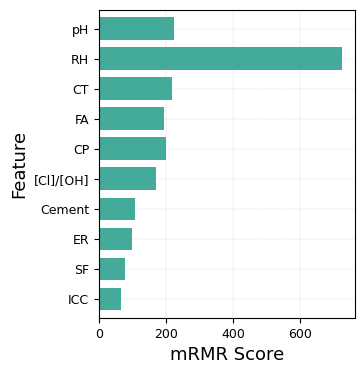

In [ ]:
# feature selection
mrmr =  MaximumRelevanceMinimumRedundancy(k=10,
        kind='regression',
        redundancy_func='p',
        relevance_func='f')

# Fit mrmr model
mrmr = mrmr.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[mrmr.selected_features_].to_list()


# Feature scores
feature_scores = mrmr.scores_

pd.Series(feature_scores, index=selected_features, name="mRMR Score").to_csv("results/eda/mRMR_scores_for_selected_features.csv")
pd.Series(feature_scores, index=selected_features, name="mRMR Score") \
    .iloc[::-1] \
    .plot.barh(figsize=(3.3, 4), width=0.75, color=COLORS['teal'])

plt.xlabel("mRMR Score")
plt.ylabel("Feature")

plt.savefig("results/eda/mRMR_scores_for_selected_features.png")
plt.close()
gc.collect()

In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print(X_train_selected.shape, X_test_selected.shape)

(220, 10) (55, 10)


In [ ]:
X_train_selected.to_csv("results/modeling/X_train_selected.csv", index=False)
X_test_selected.to_csv("results/modeling/X_test_selected.csv", index=False)
X_train.to_csv("results/modeling/X_train.csv", index=False)
X_test.to_csv("results/modeling/X_test.csv", index=False)
y_train.to_csv("results/modeling/y_train.csv", index=False)
y_test.to_csv("results/modeling/y_test.csv", index=False)

# Modeling

## Lasso with all features

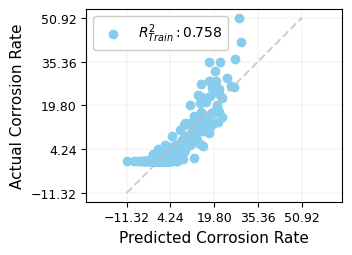

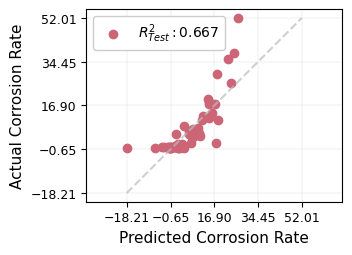

,Metric,Train,Test
0,MAE,3.461828,4.013360
1,MSE,22.030717,39.765911
2,RMSE,4.693689,6.306022
3,MAPE,42.726834,48.039141
4,R2,0.757902,0.666814


In [ ]:
lasso = Lasso(random_state=SEED, max_iter=10000)
alphas = np.logspace(-5, -0.5, 100)


tuned_parameters = [{"alpha": alphas}]
grid_search_cv = GridSearchCV(
    lasso,
    tuned_parameters,
    cv=KFold(5),
    scoring="neg_root_mean_squared_error",
    refit=False,
)
grid_search_cv.fit(X_train, y_train)
scores = grid_search_cv.cv_results_["mean_test_score"]
scores_std = grid_search_cv.cv_results_["std_test_score"]

plt.figure().set_size_inches(3.3, 2.5)
plt.semilogx(alphas, -scores, color=COLORS["wine"])  # negate the scores

std_error = scores_std / np.sqrt(5)

plt.semilogx(
    alphas, -scores - std_error, "--", color=COLORS["cyan"], zorder=0
)  # negate the scores
plt.semilogx(
    alphas, -scores + std_error, "--", color=COLORS["cyan"], zorder=0
)  # negate the scores

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(
    alphas,
    -scores - std_error,
    -scores + std_error,
    alpha=0.2,
    color=COLORS["sand"],
    zorder=1,
)  # negate the scores

plt.ylabel("RMSE +/- std error", fontsize=11)
plt.xlabel("Alpha", fontsize=11)
plt.axhline(
    -np.max(scores), linestyle="--", color=COLORS["indigo"], zorder=0
)  # negate the score
plt.xlim([alphas[0], alphas[-1]])
plt.savefig("results/modeling/Alpha Selection for Lasso.png")
plt.close()


lasso = Lasso(random_state=SEED, max_iter=10000, alpha=0.0001)
lasso.fit(X_train, y_train)

model_name="Lasso"

plot_actual_vs_predicted(
    model=lasso,
    X=X_train,
    y=y_train,
    target_name=TARGET_NAME,
    dataset="Train",
    color=COLORS["cyan"],
    save_file=True,
    model_name=model_name,
)

plot_actual_vs_predicted(
    model=lasso,
    X=X_test,
    y=y_test,
    target_name=TARGET_NAME,
    dataset="Test",
    color=COLORS["rose"],
    save_file=True,
    model_name=model_name,
)

evaluate_model(
    model=lasso,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    save=True,
    model_name=model_name,
)


In [ ]:
# Get the feature names from the trained model
feature_names = X_train.columns.tolist()

# Get the coefficients from the Lasso model.
coefficients = lasso.coef_

# Create the formula string
formula = TARGET_NAME + " = "

for i, coef in enumerate(coefficients):
    if coef != 0:
        formula += f"{coef:.4f} * {feature_names[i]} + "
formula = formula + f"{lasso.intercept_:0.4f}"

with open("results/interpretation/lasso_formula.txt", "w") as f:
    f.write(formula)

print(formula)


Corrosion Rate = -0.0239 * Cement + -0.0266 * GGBS + 0.0559 * FA + 0.0051 * SF + -7.0886 * W/B + -7.6057 * ICC + 7.8971 * FCC + -2.8726 * pH + 150.2896 * Porosity + -0.0860 * RH + 41.7179 * DoS + -1.8047 * WaterC + -0.0075 * CP + -0.0019 * ER + -0.0001 * [Cl]/[OH] + -13.2281 * CT + 12.2225


### uncertainty quantification (LASSO)

In [ ]:
# Initialize the conformal predictor using MapieRegressor
conformal_predictor_lasso = MapieRegressor(
    estimator=Lasso(random_state=SEED, max_iter=10000, alpha=0.0001)
,  # CatBoost model as the base estimator
    method="plus",  # Method for conformal prediction; 'plus' indicates the use of the plus method
    cv=LeaveOneOut(),  # Number of cross-validation folds to use
    random_state=SEED,  # Set random seed for reproducibility
)

# Fit the conformal predictor to the training data
conformal_predictor_lasso.fit(X_train, y_train)

jacknife_result_dict = {}
for alpha in np.arange(0.05, 1, 0.05):
    y_pred, y_pis = conformal_predictor_lasso.predict(X_test, alpha=alpha)
    y_lower, y_upper = y_pis[:, 0, :].squeeze(), y_pis[:, 1, :].squeeze()
    coverage = regression_coverage_score(y_test, y_lower, y_upper)
    mean_width = regression_mean_width_score(y_lower, y_upper)
    jacknife_result_dict[f"{np.round(alpha, 2)}"] = {
        "coverage": coverage,
        "mean_width": mean_width,
    }

pd.DataFrame.from_dict(jacknife_result_dict).T.to_csv(
    f"results/modeling/cvplus_results_for_lasso.csv"
)


In [ ]:
ALPHA = 0.3

y_pred, y_pis = conformal_predictor_lasso.predict(X_test, alpha=ALPHA)
y_lower, y_upper = y_pis[:, 0, :].squeeze(), y_pis[:, 1, :].squeeze()

sorted_indices = y_test.to_numpy().argsort()

y_test_sorted = y_test.to_numpy()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
y_lower_sorted = y_lower[sorted_indices]
y_upper_sorted = y_upper[sorted_indices]

outside_interval = (y_test_sorted < y_lower_sorted) | (y_test_sorted > y_upper_sorted)

# Plot the data
title = (
    f"Coverage Score = "
    f" {np.round(regression_coverage_score(y_test, y_lower, y_upper), 3)}, "
    f"and Mean Width = "
    f"{np.round(regression_mean_width_score(y_lower, y_upper), 3)} "
    f"(α = {ALPHA})"
)


plt.figure(figsize=(3.3 * 2, 2.5))
plt.plot(
    y_test_sorted,
    label="Observation",
    marker="o",
    color=COLORS["indigo"],
    zorder=1,
    markersize=5,
)
plt.plot(
    y_pred_sorted,
    label="Prediction",
    marker="o",
    color=COLORS["green"],
    zorder=1,
    markersize=5,
)
plt.fill_between(
    range(len(y_test_sorted)),
    y_lower_sorted,
    y_upper_sorted,
    alpha=0.8,
    label="Confidence Interval",
    zorder=0,
    color=COLORS["sand"],
)

plt.scatter(
    np.where(outside_interval)[0],
    y_test_sorted[outside_interval],
    marker="*",
    color=COLORS["purple"],
    s=50,
    zorder=2,
    label="Outside Prediction Interval",
)

plt.xlabel(f"Instances Sorted by {TARGET_NAME}")
plt.ylabel(TARGET_NAME)
plt.title(title)
plt.legend()
# plt.savefig(f"results/modeling/cvplus_Uncertainty_Quantification_Test_lasso.png")
# plt.close()


## Catboost with all features

## HyperParameter Tuning

In [ ]:
def objective_cat(trial):

    # Define the hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 10, 1000),
        "depth": trial.suggest_int("depth", 1, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 30),
    }

    model = CatBoostRegressor(random_state=SEED, silent=True, **params)
    score = -np.mean(
        cross_val_score(
            model,
            X_train,
            y_train,
            cv=KFold(n_splits=5),
            n_jobs=-1,
            scoring="neg_root_mean_squared_error",
        )
    )
    return score


study_cat = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(),
)
study_cat.optimize(objective_cat, n_trials=n_trials)


## Retraining the model on train set

In [ ]:
# found on trial 131
best_params = {
    "iterations": 938,
    "depth": 5,
    "learning_rate": 0.14024972369407498,
    "random_strength": 0.646183079987672,
    "bagging_temperature": 0.9288263199956079,
    "border_count": 36,
    "l2_leaf_reg": 8,
}

pd.Series(best_params, name="best_params_for_catboost_for_all_features")\
    .to_csv("results/modeling/best_params_for_catboost_for_all_features.csv")


# Initialize the CatBoostRegressor with the best parameters and a fixed random seed
cat = CatBoostRegressor(random_state=SEED, silent=True, **best_params)

# Fit the model to the training data with selected features
cat.fit(X_train, y_train)

model_name = "catboost_trained_on_all_features"

plot_actual_vs_predicted(
    model=cat,
    X=X_train,
    y=y_train,
    target_name=TARGET_NAME,
    dataset="Train",
    color=COLORS["cyan"],
    save_file=True,
    model_name=model_name,
)

plot_actual_vs_predicted(
    model=cat,
    X=X_test,
    y=y_test,
    target_name=TARGET_NAME,
    dataset="Test",
    color=COLORS["rose"],
    save_file=True,
    model_name=model_name,
)

evaluate_model(
    model=cat,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    save=True,
    model_name=model_name,
)


## Catboost with selected features

## Hyperparameter tuning

In [ ]:
def objective_cat_mrmr(trial):

    # Define the hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 10, 1000),
        "depth": trial.suggest_int("depth", 1, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 30),
    }

    model = CatBoostRegressor(random_state=SEED, silent=True, **params)
    score = -np.mean(
        cross_val_score(
            model,
            X_train_selected,
            y_train,
            cv=KFold(n_splits=5),
            n_jobs=-1,
            scoring="neg_root_mean_squared_error",
        )
    )
    return score


study_cat_mrmr = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(),
)
study_cat_mrmr.optimize(objective_cat_mrmr, n_trials=n_trials)


## Retraining the model on train set

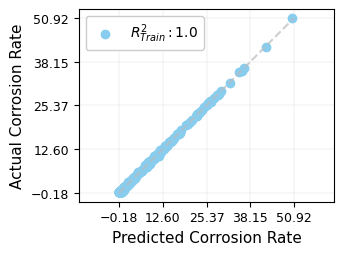

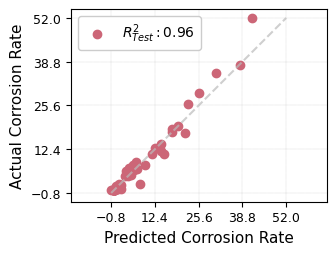

,Metric,Train,Test
0,MAE,0.140989,1.183328
1,MSE,0.036899,4.729254
2,RMSE,0.192090,2.174685
3,MAPE,1.086791,2.756105
4,R2,0.999595,0.960375


In [ ]:
# found on trial 121
best_params_mrmr = {
    'iterations': 879,
    'depth': 4,
    'learning_rate': 0.2725476330022533,
    'random_strength': 0.9725913031985871,
    'bagging_temperature': 0.4311392086521878,
    'border_count': 27,
    'l2_leaf_reg': 23
}

pd.Series(best_params_mrmr, name="best_params_for_catboost_for__mrmr")\
    .to_csv("results/modeling/best_params_for_catboost_for_mrmr.csv")


# Initialize the CatBoostRegressor with the best parameters and a fixed random seed
cat_mrmr = CatBoostRegressor(random_state=SEED, silent=True, **best_params_mrmr)

# Fit the model to the training data with selected features
cat_mrmr.fit(X_train_selected, y_train)

model_name = "catboost_trained_on_selected_features"



plot_actual_vs_predicted(
    model=cat_mrmr,
    X=X_train_selected,
    y=y_train,
    target_name=TARGET_NAME,
    dataset="Train",
    color=COLORS["cyan"],
    save_file=True,
    model_name=model_name,
)

plot_actual_vs_predicted(
    model=cat_mrmr,
    X=X_test_selected,
    y=y_test,
    target_name=TARGET_NAME,
    dataset="Test",
    color=COLORS["rose"],
    save_file=True,
    model_name=model_name,
)

evaluate_model(
    model=cat_mrmr,
    X_train=X_train_selected,
    X_test=X_test_selected,
    y_train=y_train,
    y_test=y_test,
    save=True,
    model_name=model_name,
)


### uncertainty quantification (CATBOOST mRMR features)

In [ ]:
# Initialize the conformal predictor using MapieRegressor
conformal_predictor = MapieRegressor(
    estimator=CatBoostRegressor(
        random_state=SEED, silent=True, **best_params_mrmr
    ),  # CatBoost model as the base estimator
    method="plus",  # Method for conformal prediction; 'plus' indicates the use of the plus method
    cv=LeaveOneOut(),  # Number of cross-validation folds to use
    random_state=SEED,  # Set random seed for reproducibility
)

# Fit the conformal predictor to the training data
conformal_predictor.fit(X_train_selected, y_train)

jacknife_result_dict = {}
for alpha in np.arange(0.05, 1, 0.05):
    y_pred, y_pis = conformal_predictor.predict(X_test_selected, alpha=alpha)
    y_lower, y_upper = y_pis[:, 0, :].squeeze(), y_pis[:, 1, :].squeeze()
    coverage = regression_coverage_score(y_test, y_lower, y_upper)
    mean_width = regression_mean_width_score(y_lower, y_upper)
    jacknife_result_dict[f"{np.round(alpha, 2)}"] = {
        "coverage": coverage,
        "mean_width": mean_width,
    }

pd.DataFrame.from_dict(jacknife_result_dict).T.to_csv(
    f"results/modeling/cvplus_results.csv"
)


In [ ]:
ALPHA = 0.1

y_pred, y_pis = conformal_predictor.predict(X_test_selected, alpha=ALPHA)
y_lower, y_upper = y_pis[:, 0, :].squeeze(), y_pis[:, 1, :].squeeze()

sorted_indices = y_test.to_numpy().argsort()

y_test_sorted = y_test.to_numpy()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
y_lower_sorted = y_lower[sorted_indices]
y_upper_sorted = y_upper[sorted_indices]

outside_interval = (y_test_sorted < y_lower_sorted) | (y_test_sorted > y_upper_sorted)

# Plot the data
title = (
    f"Coverage Score = "
    f" {np.round(regression_coverage_score(y_test, y_lower, y_upper), 3)}, "
    f"and Mean Width = "
    f"{np.round(regression_mean_width_score(y_lower, y_upper), 3)} "
    f"(α = {ALPHA})"
)


plt.figure(figsize=(3.3 * 2, 2.5))
plt.plot(
    y_test_sorted,
    label="Observation",
    marker="o",
    color=COLORS["indigo"],
    zorder=1,
    markersize=5,
)
plt.plot(
    y_pred_sorted,
    label="Prediction",
    marker="o",
    color=COLORS["green"],
    zorder=1,
    markersize=5,
)
plt.fill_between(
    range(len(y_test_sorted)),
    y_lower_sorted,
    y_upper_sorted,
    alpha=0.8,
    label="Confidence Interval",
    zorder=0,
    color=COLORS["sand"],
)

plt.scatter(
    np.where(outside_interval)[0],
    y_test_sorted[outside_interval],
    marker="*",
    color=COLORS["purple"],
    s=50,
    zorder=2,
    label="Outside Prediction Interval",
)

plt.xlabel(f"Instances Sorted by {TARGET_NAME}")
plt.ylabel(TARGET_NAME)
plt.title(title)
plt.legend()
plt.savefig(f"results/modeling/cvplus_Uncertainty_Quantification_Test.png")
plt.close()


# Interpretation




## Shap


In [ ]:
# Explain the model's predictions using SHAP values
explainer = shap.Explainer(cat_mrmr)
shap_values = explainer(X[selected_features])

In [ ]:
# Assuming 'shap_values' is your Explanation object
# Calculate feature importance
feature_importances = np.abs(shap_values.values).mean(axis=0)  # Use np.abs()

# Convert the feature importances to a DataFrame for easier interpretation
feature_importance_df = pd.Series(
    feature_importances, index=selected_features, name="importance"
)

# # Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(ascending=True)

feature_importance_df.to_csv(
    "results/interpretation/feature_importance_by_shap_values.csv"
)
feature_importance_df.plot.barh(
    figsize=(3.3, 5 * (10 / 16)), width=0.75, color=COLORS["olive"]
)
plt.savefig("results/interpretation/feature_importance_by_shap_values.png")
plt.close()


In [ ]:
mixture_parameters_importance = (
    feature_importance_df["FA"]
    + feature_importance_df["SF"]
    + feature_importance_df["ICC"]
    + feature_importance_df["Cement"]
) / feature_importance_df.sum()
materials_properties = (feature_importance_df["pH"]) / feature_importance_df.sum()
environmental_parameters = (feature_importance_df["RH"]) / feature_importance_df.sum()
mixture_parameters_importance = (
    feature_importance_df["CP"]
    + feature_importance_df["ER"]
    + feature_importance_df["[Cl]/[OH]"]
) / feature_importance_df.sum()
contamination_type_importance = (
    feature_importance_df["CT"] / feature_importance_df.sum()
)


In [ ]:
# Define feature importance based on categories
# Assuming feature_importance_df is already defined from SHAP values
mixture_parameters_importance = (
    feature_importance_df["FA"]
    + feature_importance_df["SF"]
    + feature_importance_df["ICC"]
    + feature_importance_df["Cement"]
) / feature_importance_df.sum()
materials_properties_importance = (
    feature_importance_df["pH"]
) / feature_importance_df.sum()
environmental_parameters_importance = (
    feature_importance_df["RH"]
) / feature_importance_df.sum()
electrochemical_parameters_importance = (
    feature_importance_df["CP"]
    + feature_importance_df["ER"]
    + feature_importance_df["[Cl]/[OH]"]
) / feature_importance_df.sum()
contamination_type_importance = (
    feature_importance_df["CT"] / feature_importance_df.sum()
)

# Data for the pie chart
labels = [
    "Mixture Parameters",
    "Materials Properties",
    "Environmental Parameters",
    "Electrochemical Parameters",
    "Contamination Type",
]
sizes = [
    mixture_parameters_importance,
    materials_properties_importance,
    environmental_parameters_importance,
    electrochemical_parameters_importance,
    contamination_type_importance,
]
colors = [
    COLORS["cyan"],
    COLORS["wine"],
    COLORS["teal"],
    COLORS["purple"],
    COLORS["olive"],
]  # Using your defined COLORS

# Create the pie chart
fig, ax = plt.subplots(figsize=(3.3, 2.5))  # Reduced figure size
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 7},
)  # Smaller font size

# Improve text visibility and format with consistent font weight
ax.axis("equal")
plt.setp(autotexts, size=8, weight="normal")  # Matching font weight for numbers
# plt.title('Feature Importance by Category')  # Add a title if desired

# Save and show the plot
plt.savefig("results/interpretation/feature_importance_pie_chart.png")
plt.close()

In [ ]:
shap.plots.beeswarm(shap_values, show=False)
for loc in ["top", "right", "bottom", "left"]:
    plt.gca().spines[loc].set_visible(True)
    plt.gca().spines[loc].set_color("black")
plt.savefig("results/interpretation/feature_correlation_big_picture_by_shap_values.png")
plt.close()


In [ ]:
for idx, feature in enumerate(selected_features, start=1111):
    fig, ax = plt.subplots(figsize=(3.3, 2.5))
    shap.plots.scatter(shap_values[:, feature], ax=ax, show=False, axis_color='black', hist=False)
    for loc in ["top", "right", "bottom", "left"]:
        plt.gca().spines[loc].set_visible(True)
        plt.gca().spines[loc].set_color("black")
    plt.savefig(f"results/interpretation/{idx}_scatter_plot.png")
    plt.close()
gc.collect()


28893

In [ ]:
fig, ax = plt.subplots(figsize=(3.3, 5 * (10 / 16)))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), ax=ax, show=False)
for loc in ["right", "bottom", "left"]:
    plt.gca().spines[loc].set_visible(True)
    plt.gca().spines[loc].set_color("black")
plt.savefig(f"results/interpretation/heatmap_plot.png")
plt.close()

## shapiq


In [ ]:
explainer_2 = shapiq.TabularExplainer(
    cat_mrmr, X[selected_features].to_numpy(), index="k-SII", max_order=3
)
n_features = len(selected_features)


In [ ]:
mask_where_we_have_high_pH_and_high_corrosion = list(
    np.where(
        (y > y.quantile(q=[0.25, 0.5, 0.75]).loc[0.75])
        & (X.pH > X.pH.quantile(q=[0.25, 0.5, 0.75]).loc[0.5])
    )[0]
)
y.quantile(q=[0.25, 0.5, 0.75]).to_csv(
    "results/interpretation/corrosion_rate_quantiles.csv"
)
X.pH.quantile(q=[0.25, 0.5, 0.75]).to_csv("results/interpretation/pH_quantiles.csv")
df.iloc[mask_where_we_have_high_pH_and_high_corrosion].to_csv(
    "results/interpretation/samples_where_we_have_high_pH_more_than_median_and_high_corrosion_more_than_third_quantile.csv"
)

df.iloc[mask_where_we_have_high_pH_and_high_corrosion]

,Cement,GGBS,FA,SF,W/B,ICC,FCC,pH,Porosity,RH,DoS,WaterC,CP,ER,[Cl]/[OH],CT,Corrosion Rate
99,100.0,0.0,0.0,0.0,0.45,2.0,1.32232,12.591082,0.159736,97.0,1.000000,7.986791,-579.083333,81.520408,58.854214,0,13.679069
122,86.0,0.0,0.0,14.0,0.45,1.2,0.80936,13.085143,0.192167,97.0,0.969090,9.311346,-591.983333,140.080700,9.927191,0,17.582747
129,100.0,0.0,0.0,0.0,0.45,2.0,1.32232,12.591082,0.159736,92.0,0.842425,6.728274,-578.966667,92.493796,58.854214,0,12.697198
152,86.0,0.0,0.0,14.0,0.45,1.2,0.80936,13.085143,0.192167,92.0,0.858574,8.249478,-564.216667,198.240991,9.927191,0,12.751221


In [ ]:

for idx in mask_where_we_have_high_pH_and_high_corrosion:
    to_help_naming = round(y.iloc[idx])
    sample = X[selected_features].iloc[idx].to_numpy()

    shap_interaction_values_of_sample = explainer_2.explain(
        sample,
        budget=2**n_features,
        random_state=SEED,
    )
    shapiq.network_plot(
        first_order_values=shap_interaction_values_of_sample.get_n_order_values(1),
        second_order_values=shap_interaction_values_of_sample.get_n_order_values(2),
        feature_names=X_test_selected.columns,
        show=False,
        draw_legend=False,
    )

    plt.savefig(
        f"results/interpretation/network_plot_sample_with_corrosion_rate_of_{to_help_naming}_with_idx_{idx}"
    )

    shapiq.plot.force.force_plot(
        interaction_values=shap_interaction_values_of_sample,
        feature_names=X_test_selected.columns,
        min_percentage=0.05,
        figsize=(10, 2.5),
    )

    plt.savefig(
        f"results/interpretation/force_plot_sample_with_corrosion_rate_of_{to_help_naming}_with_idx_{idx}"
    )


In [ ]:
index_of_five_highest_corroded_bars = y.sort_values(ascending=False).head(5).index.to_list()
(    df
    .iloc[index_of_five_highest_corroded_bars]
    .to_csv("results/interpretation/five_highest_corroded_bars.csv")
)

for idx in index_of_five_highest_corroded_bars:
    to_help_naming = round(y.iloc[idx])
    sample = X[selected_features].iloc[idx].to_numpy()
    shap_interaction_values_of_sample = explainer_2.explain(
        sample,
        budget=2**n_features,
        random_state=SEED,
    )
    shapiq.network_plot(
        first_order_values=shap_interaction_values_of_sample.get_n_order_values(1),
        second_order_values=shap_interaction_values_of_sample.get_n_order_values(2),
        feature_names=X_test_selected.columns,
        show=False,
        draw_legend=False,
    )
    plt.savefig(
        f"results/interpretation/network_plot_sample_with_corrosion_rate_of_{to_help_naming}_with_idx_{idx}"
    )
    plt.close()
    shapiq.plot.force.force_plot(
        interaction_values=shap_interaction_values_of_sample,
        feature_names=X_test_selected.columns,
        min_percentage=0.05,
        figsize=(10, 2.5),
    )
    plt.savefig(
        f"results/interpretation/force_plot_sample_with_corrosion_rate_of_{to_help_naming}_with_idx_{idx}"
    )
    plt.close()
gc.collect()


120394

In [ ]:
index_of_five_lowest_corroded_bars = y.sort_values(ascending=True).head(5).index.to_list()

df \
    .iloc[index_of_five_lowest_corroded_bars]\
    .to_csv("results/interpretation/five_lowest_corroded_bars.csv")


for idx in index_of_five_lowest_corroded_bars:
    to_help_naming = round(y.iloc[idx])
    sample = X[selected_features].iloc[idx].to_numpy()
    shap_interaction_values_of_sample = explainer_2.explain(
        sample,
        budget=2**n_features,
        random_state=SEED,
    )
    shapiq.network_plot(
        first_order_values=shap_interaction_values_of_sample.get_n_order_values(1),
        second_order_values=shap_interaction_values_of_sample.get_n_order_values(2),
        feature_names=X_test_selected.columns,
        show=False,
        draw_legend=False,
    )
    plt.savefig(
        f"results/interpretation/network_plot_sample_with_corrosion_rate_of_{to_help_naming}_with_idx_{idx}"
    )
    plt.show()
    # plt.close()
    shapiq.plot.force.force_plot(
        interaction_values=shap_interaction_values_of_sample,
        feature_names=X_test_selected.columns,
        min_percentage=0.05,
        figsize=(10, 2.5),
    )
    plt.savefig(
        f"results/interpretation/force_plot_sample_with_corrosion_rate_of_{to_help_naming}_with_idx_{idx}"
    )
    plt.show()
    # plt.close()
gc.collect()


In [ ]:
import zipfile
import os
from datetime import date

# Get today's date
today = date.today()

# Format the date as YYYY-MM-DD
date_str = today.strftime("%Y-%m-%d")

# Specify the directory to zip
directory_to_zip = "results"

# Specify the output zip file name with today's date
output_filename = f"results_{date_str}.zip"

# Create a zip file
with zipfile.ZipFile(output_filename, "w") as zip_ref:
    # Walk through the directory and add all files to the zip
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            # Use relative path to maintain directory structure in the zip
            relative_path = os.path.relpath(
                file_path, start=os.path.dirname(directory_to_zip)
            )
            zip_ref.write(file_path, arcname=relative_path)

print(f"Created archive {output_filename}")
